<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lecture-overview" data-toc-modified-id="Lecture-overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lecture overview</a></span></li><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Grouping-your-data:-the-.groupby()-function" data-toc-modified-id="Grouping-your-data:-the-.groupby()-function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grouping your data: the <code>.groupby()</code> function</a></span></li><li><span><a href="#The-.apply()-and-.transform()-methods" data-toc-modified-id="The-.apply()-and-.transform()-methods-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The <code>.apply()</code> and <code>.transform()</code> methods</a></span></li><li><span><a href="#Winsorizing-outliers" data-toc-modified-id="Winsorizing-outliers-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Winsorizing outliers</a></span></li></ul></div>

# Lecture overview

In this lecture we introduce a set of Pandas functions that are very useful in describing subsamples of your data (this is often called "subsample analysis"). Looking at subsamples of your data individually is important because patterns that show up in your overall dataset may look quite different if you limit yourself to a subset of the dataset. This is exemplified in Simpson's Paradox: https://en.wikipedia.org/wiki/Simpson%27s_paradox.

We finish the lecture with a discussion of the impact of outliers on your descriptive statistics, and a method of mitigating that impact called "windsorization".

# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
pd.options.display.max_rows = 20

We'll use data on the Fama-French 5-industry portfolio returns for this lecture:

In [2]:
#raw = pdr.DataReader(name = '5_Industry_Portfolios', data_source = 'famafrench', 
#                     start = '2011-01-01', end = '2022-12-31')
#raw[3].to_pickle('./ff5.pkl')
#raw
raw = pd.read_csv('./ff5.csv')
raw

,Date,Cnsmr,Manuf,HiTec,Hlth,Other
0,2011,-6.68,-6.02,-13.44,-10.95,-10.44
1,2012,21.96,8.97,10.64,25.44,25.86
2,2013,43.79,37.33,50.77,56.15,42.23
3,2014,4.63,-8.46,2.41,14.20,8.06
4,2015,-9.48,-22.43,-3.48,2.35,-3.08
5,2016,16.03,33.62,17.35,-11.21,30.89
6,2017,6.51,10.37,25.93,25.49,14.46
7,2018,-14.25,-22.04,-6.61,-22.48,-13.64
8,2019,17.60,12.04,27.65,25.96,26.31
9,2020,42.68,18.60,65.98,63.63,12.59


Extract equal-weighted *annual* industry returns, and turn them to decimal (they are in percentage points):

In [3]:
ew = raw.set_index('Date')/100
ew

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,-0.0668,-0.0602,-0.1344,-0.1095,-0.1044
2012,0.2196,0.0897,0.1064,0.2544,0.2586
2013,0.4379,0.3733,0.5077,0.5615,0.4223
2014,0.0463,-0.0846,0.0241,0.1420,0.0806
2015,-0.0948,-0.2243,-0.0348,0.0235,-0.0308
2016,0.1603,0.3362,0.1735,-0.1121,0.3089
2017,0.0651,0.1037,0.2593,0.2549,0.1446
2018,-0.1425,-0.2204,-0.0661,-0.2248,-0.1364
2019,0.1760,0.1204,0.2765,0.2596,0.2631


Let's take a look at the data:

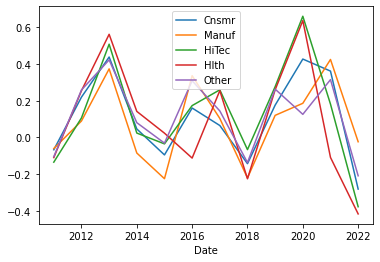

In [4]:
ew.plot();

Calculate cumulative products of gross returns (i.e. compound returns over time) and plot them:

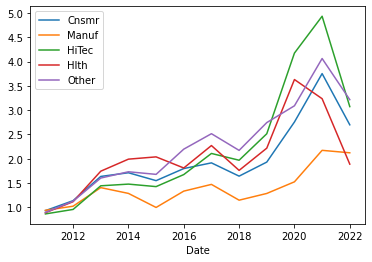

In [5]:
(1 + ew).cumprod().plot();

Stack industry returns on top of each other for the purpose of this class:

In [6]:
ew_long = ew.stack().to_frame(name = 'ewret')
ew_long.head(10)

ewret
Date              
2011 Cnsmr -0.0668
     Manuf -0.0602
     HiTec -0.1344
     Hlth  -0.1095
     Other -0.1044
2012 Cnsmr  0.2196
     Manuf  0.0897
     HiTec  0.1064
     Hlth   0.2544
     Other  0.2586

And bring date and industry names as data inside the dataframe:

In [7]:
ew_long = ew_long.reset_index().rename(columns={'level_1':'Industry'})
ew_long

,Date,Industry,ewret
0,2011,Cnsmr,-0.0668
1,2011,Manuf,-0.0602
2,2011,HiTec,-0.1344
3,2011,Hlth,-0.1095
4,2011,Other,-0.1044
...,...,...,...
55,2022,Cnsmr,-0.2808
56,2022,Manuf,-0.0233
57,2022,HiTec,-0.3769
58,2022,Hlth,-0.4160


**Challenge:**

Do the same for value-weighted annual returns (i.e. create a "vw_long" dataframe, using the same steps we used for "ew_long":

In [8]:
vw = pd.read_csv('./ff5vw.csv').set_index('Date')/100
vw
#vw = raw[2]/100
#vw

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,0.0905,0.0447,0.0049,0.1087,-0.0989
2012,0.1630,0.0881,0.1673,0.2035,0.2227
2013,0.3299,0.2918,0.3365,0.4119,0.4086
2014,0.1267,0.0338,0.1448,0.2446,0.1234
2015,0.0689,-0.1164,0.0383,0.0580,-0.0115
2016,0.0546,0.2034,0.1398,-0.0185,0.2016
2017,0.1869,0.1816,0.2950,0.2220,0.2152
2018,-0.0358,-0.1110,-0.0059,0.0482,-0.0921
2019,0.2588,0.2121,0.4176,0.2020,0.2951


In [9]:
vw_long = (vw).stack().to_frame(name='vwret').reset_index().rename(columns={'level_1':'Industry'})
vw_long

,Date,Industry,vwret
0,2011,Cnsmr,0.0905
1,2011,Manuf,0.0447
2,2011,HiTec,0.0049
3,2011,Hlth,0.1087
4,2011,Other,-0.0989
...,...,...,...
55,2022,Cnsmr,-0.2501
56,2022,Manuf,0.0446
57,2022,HiTec,-0.3239
58,2022,Hlth,-0.0542


Merge the EW returns and VW returns into a single dataframe called "ireturns":

In [10]:
ireturns = ew_long.merge(vw_long, how='inner', on = ['Date','Industry'])
ireturns

,Date,Industry,ewret,vwret
0,2011,Cnsmr,-0.0668,0.0905
1,2011,Manuf,-0.0602,0.0447
2,2011,HiTec,-0.1344,0.0049
3,2011,Hlth,-0.1095,0.1087
4,2011,Other,-0.1044,-0.0989
...,...,...,...,...
55,2022,Cnsmr,-0.2808,-0.2501
56,2022,Manuf,-0.0233,0.0446
57,2022,HiTec,-0.3769,-0.3239
58,2022,Hlth,-0.4160,-0.0542


# Grouping your data: the ``.groupby()`` function

The ``.groupby()`` function can be used to tell Python that you want to split your data into groups. The parameters of the ``.groupby()`` function tell Python *how* those groups should be created. The purpose is usually to apply some function (e.g. the ".mean()" function) to each of these groups separately.

Abbreviated syntax:
```python
DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, dropna=True)
```

The most important parameter is ``by``. This is where you tell Python which column (or index) in your DataFrame contains the information based on which you want to group your data. Python will split your DataFrame into "mini" dataframes, one for each unique value of the variable(s) you supplied to the ``by`` parameter.

For example, the line below splits ``ireturns`` into 5 different dataframes, one for each unique entry found in the "Industry" column, and then applies the ``.mean()`` function for each of these 5 dataframes separately. Finally, these subsample means are all collected into a new dataframe ``ind_means``: 

In [11]:
ind_means = ireturns.groupby(by = 'Industry')[['ewret','vwret']].mean()
ind_means

,ewret,vwret
Industry,,
Cnsmr,0.109033,0.131017
HiTec,0.131392,0.158875
Hlth,0.096767,0.145658
Manuf,0.085083,0.095575
Other,0.119892,0.123650


If you don't want the ``by`` variable (i.e. "Industry" in the example above) to be the index of the resulting dataframe:

In [12]:
an_means = ireturns.groupby('Date', as_index=False).mean()
an_means

,Date,ewret,vwret
0,2011,-0.09506,0.02998
1,2012,0.18574,0.16892
2,2013,0.46054,0.35574
3,2014,0.04168,0.13466
4,2015,-0.07224,0.00746
5,2016,0.17336,0.11618
6,2017,0.16552,0.22014
7,2018,-0.15804,-0.03932
8,2019,0.21912,0.27712
9,2020,0.40696,0.21164


Another example, with a different ``by`` variable and a different function applied to each group (i.e. median instead of mean):

In [13]:
twodim = ireturns.groupby(['Date','Industry']).mean()
twodim

ewret   vwret
Date Industry                
2011 Cnsmr    -0.0668  0.0905
     HiTec    -0.1344  0.0049
     Hlth     -0.1095  0.1087
     Manuf    -0.0602  0.0447
     Other    -0.1044 -0.0989
...               ...     ...
2022 Cnsmr    -0.2808 -0.2501
     HiTec    -0.3769 -0.3239
     Hlth     -0.4160 -0.0542
     Manuf    -0.0233  0.0446
     Other    -0.2085 -0.1230

[60 rows x 2 columns]

You can group by more than one variable:

In [14]:
ireturns.groupby(['Date','Industry']).count()

ewret  vwret
Date Industry              
2011 Cnsmr         1      1
     HiTec         1      1
     Hlth          1      1
     Manuf         1      1
     Other         1      1
...              ...    ...
2022 Cnsmr         1      1
     HiTec         1      1
     Hlth          1      1
     Manuf         1      1
     Other         1      1

[60 rows x 2 columns]

The example above did not really change the ``ireturns`` dataframe, since each "Date" x "Industry" pair has a single entry for both "ewret" and "vwret". Since the mean of a single number is the number itself, the ``twodim`` dataframe will be identical to ``ireturns``. Note that this is not necessarily the case if we used a different function instead of ``.mean()``, for example ``.count()``:

You can specify which variable(s) you want to apply the function to, in brackets, right before the function name (if you leave this out (like above), the function will be applied to all the columns in the dataframe):

In [15]:
ind_ew_medians = ireturns.groupby('Industry')[['ewret']].median()
ind_ew_medians

,ewret
Industry,
Cnsmr,0.11270
HiTec,0.13995
Hlth,0.08275
Manuf,0.09670
Other,0.13525


# The ``.apply()`` and ``.transform()`` methods

The ``.apply()`` and ``.transform()``  methods do similar things: they can be used to tell Python to apply a given function to some data from a dataframe. As the examples above show, there are many Pandas functions, like ``.mean()`` and ``.median()`` that can do this without the help of ``.apply()`` or ``.transform()`` (we just have to add the names of these functions after the ``.groupby()`` statement, just like we did above). But what if the function we want to apply is not a built-in Pandas function that can be applied with a dot after the name of a dataframe? This is where ``.apply()`` and ``.transform()`` come in handy. These methods are especially useful when we want to apply a particular function, separately, to each group we created with a ``.groupby`` statement. 

Here is their syntax:

Syntax for ``.transform()``:
```python
DataFrame.transform(func, axis=0, *args, **kwargs)
```
Syntax for ``.apply()``:
```python
DataFrame.apply(func, axis=0, raw=False, result_type=None, args=(), **kwargs)
```

The most important argument is ``func`` which is where we tell Python which function we want to apply to the data. 

The main difference between ``.transform()`` and ``.apply()`` is that ``.transform()`` returns a sequence of the same length as the dataframe to which it is applied, while ``.apply()`` returns a DataFrame or Series of the same size as the number of groups to which it is applied.

In [16]:
ireturns.groupby('Industry')[['ewret']].apply(func = np.median)

Industry
Cnsmr    0.11270
HiTec    0.13995
Hlth     0.08275
Manuf    0.09670
Other    0.13525
dtype: float64

In [17]:
ireturns.groupby('Industry')[['ewret']].transform(func = np.median)

,ewret
0,0.11270
1,0.09670
2,0.13995
3,0.08275
4,0.13525
...,...
55,0.11270
56,0.09670
57,0.13995
58,0.08275


We usually add the results of ``.transform()`` as a new column to the same dataframe:

In [18]:
mycopy = ireturns.copy()
mycopy['ind_medians'] = ireturns.groupby('Industry')[['ewret']].transform(func = np.median)
mycopy.head(10)

,Date,Industry,ewret,vwret,ind_medians
0,2011,Cnsmr,-0.0668,0.0905,0.11270
1,2011,Manuf,-0.0602,0.0447,0.09670
2,2011,HiTec,-0.1344,0.0049,0.13995
3,2011,Hlth,-0.1095,0.1087,0.08275
4,2011,Other,-0.1044,-0.0989,0.13525
5,2012,Cnsmr,0.2196,0.1630,0.11270
6,2012,Manuf,0.0897,0.0881,0.09670
7,2012,HiTec,0.1064,0.1673,0.13995
8,2012,Hlth,0.2544,0.2035,0.08275
9,2012,Other,0.2586,0.2227,0.13525


Note, also, that with ``.transform()``, you can pass the name of the function you want as a **string** to the ``func`` argument, whereas with ``.apply()`` you can not:

In [23]:
ireturns.groupby('Industry')[['ewret','vwret']].transform('median')

,ewret,vwret
0,0.11270,0.14485
1,0.09670,0.06640
2,0.13995,0.15605
3,0.08275,0.16085
4,0.13525,0.16250
...,...,...
55,0.11270,0.14485
56,0.09670,0.06640
57,0.13995,0.15605
58,0.08275,0.16085


Whereas the line below will not work. You have to specify which package the "median" function belongs to (which is why we used ``.apply(np.median)`` above):

In [20]:
#ireturns.groupby('Industry')[['ewret','vwret']].apply('median') #this gives an error

We are not restricted to applying functions that come with a package that we have installed. We can also use a function that we created ourselves.

For example, below, we create a function that can take in a Series or a DataFrame of returns, and compounds them:

In [21]:
def compound_returns(x):
    return (1+x).prod()-1

Now we can apply that function to the returns of each industry:

In [22]:
ireturns.groupby('Industry')[['ewret','vwret']].apply(compound_returns)

,ewret,vwret
Industry,,
Cnsmr,1.698301,2.829945
HiTec,2.072710,3.731214
Hlth,0.889443,3.776190
Manuf,1.122698,1.737139
Other,2.215085,2.533444


Let's see if it worked:

In [24]:
(1+ew).cumprod()-1

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
2011,-0.066800,-0.060200,-0.134400,-0.109500,-0.104400
2012,0.138131,0.024100,-0.042300,0.117043,0.127202
2013,0.636518,0.406397,0.443924,0.744263,0.603220
2014,0.712289,0.287415,0.478723,0.991948,0.732439
2015,0.549964,-0.001352,0.427263,1.038759,0.679080
2016,0.798423,0.334394,0.674893,0.810214,1.197748
2017,0.915501,0.472770,1.109193,1.271638,1.515542
2018,0.642542,0.148172,0.969775,0.760974,1.172422
2019,0.931629,0.286412,1.514418,1.218122,1.743986


# Winsorizing outliers 

"Winsorizing" a variable means replacing its most extreme values with less extreme values. For example, winsorizing a variable "at the 5 and 95 percentiles", means that the values of that variable that are smaller than the 5th percentile will be made equal to the 5th percentile and the values that are larger than the 95th percentile will be made equal to the 95th percentile.

You can pick other values for the percentiles at which you want to winsorize but (1,99) and (5, 95) are by far the most common ones.

To winsorize a variable, in a Pandas dataframe, we use the ``.clip()`` function as below. This also requires us to use the ``.quantile()`` function to calculate the 5th and 95th percentiles. First, let's sort the returns so we can easily see its most extreme values (top and bottom):

In [25]:
ew_long.sort_values('ewret')

,Date,Industry,ewret
58,2022,Hlth,-0.4160
57,2022,HiTec,-0.3769
55,2022,Cnsmr,-0.2808
38,2018,Hlth,-0.2248
21,2015,Manuf,-0.2243
...,...,...,...
10,2013,Cnsmr,0.4379
12,2013,HiTec,0.5077
13,2013,Hlth,0.5615
48,2020,Hlth,0.6363


Let's calculate the 5th and 95th percentiles:

In [26]:
q5 = ew_long['ewret'].quantile(0.05)
q5

-0.2276

In [27]:
q95 = ew_long['ewret'].quantile(0.95)
q95

0.5103899999999999

And now let's create a version of ``ewret`` that is winsorized at the 5 and 95 percentiles:

In [28]:
ew_long['ew_wins'] = ew_long['ewret'].clip(lower=q5, upper=q95)

Let's see if it worked:

In [30]:
ew_long.sort_values('ewret', ascending=False)

,Date,Industry,ewret,ew_wins
47,2020,HiTec,0.6598,0.51039
48,2020,Hlth,0.6363,0.51039
13,2013,Hlth,0.5615,0.51039
12,2013,HiTec,0.5077,0.50770
10,2013,Cnsmr,0.4379,0.43790
...,...,...,...,...
21,2015,Manuf,-0.2243,-0.22430
38,2018,Hlth,-0.2248,-0.22480
55,2022,Cnsmr,-0.2808,-0.22760
57,2022,HiTec,-0.3769,-0.22760
